In [ ]:
import os
import shutil
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

from Task_1.synthetic_dataset import SyntheticDataset
from Arwin.model.trainer import Trainer
from Arwin.model.deeponet import *
from Task_1.utils import collate_fn_fixed, collate_fn

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = SyntheticDataset(1000, 128, padding=False, verbose=True)
valid_dataset = SyntheticDataset(100, 128, padding=False, verbose=True, test=True)

Sampling Functions from Beta Distribution 1/6 with a=1, b=2: 100%|██████████| 166/166 [00:10<00:00, 16.23it/s]
Sampling Functions from Beta Distribution 2/6 with a=1, b=5: 100%|██████████| 166/166 [00:07<00:00, 22.24it/s]
Sampling Functions from Beta Distribution 3/6 with a=2, b=1: 100%|██████████| 166/166 [00:03<00:00, 51.03it/s] 
Sampling Functions from Beta Distribution 4/6 with a=2, b=5: 100%|██████████| 166/166 [00:09<00:00, 17.17it/s]
Sampling Functions from Beta Distribution 5/6 with a=5, b=1: 100%|██████████| 166/166 [00:17<00:00,  9.34it/s]
Sampling Functions from Beta Distribution 6/6 with a=5, b=2: 100%|██████████| 170/170 [00:14<00:00, 11.38it/s]
Generating Observations: 100%|██████████| 1000/1000 [00:00<00:00, 10063.71it/s]
Sampling Functions from Beta Distribution 1/6 with a=1, b=2: 100%|██████████| 16/16 [00:00<00:00, 33.68it/s]
Sampling Functions from Beta Distribution 2/6 with a=1, b=5: 100%|██████████| 16/16 [00:01<00:00,  8.81it/s]
Sampling Functions from Beta Distri

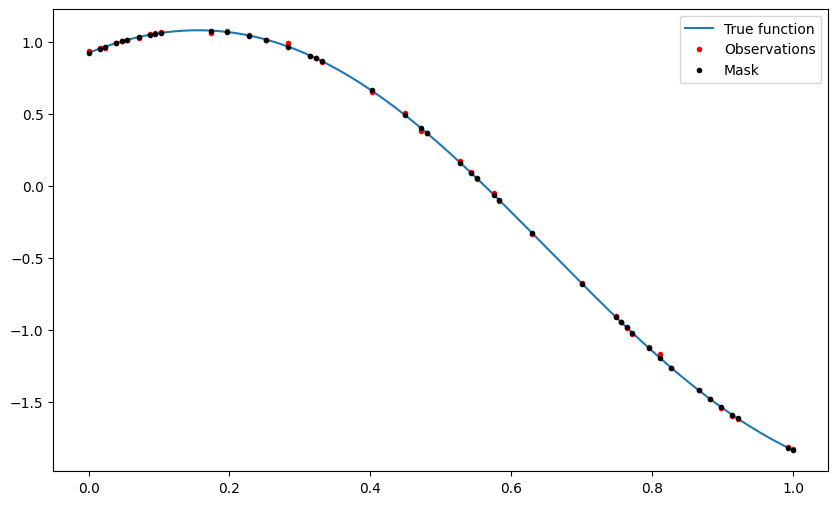

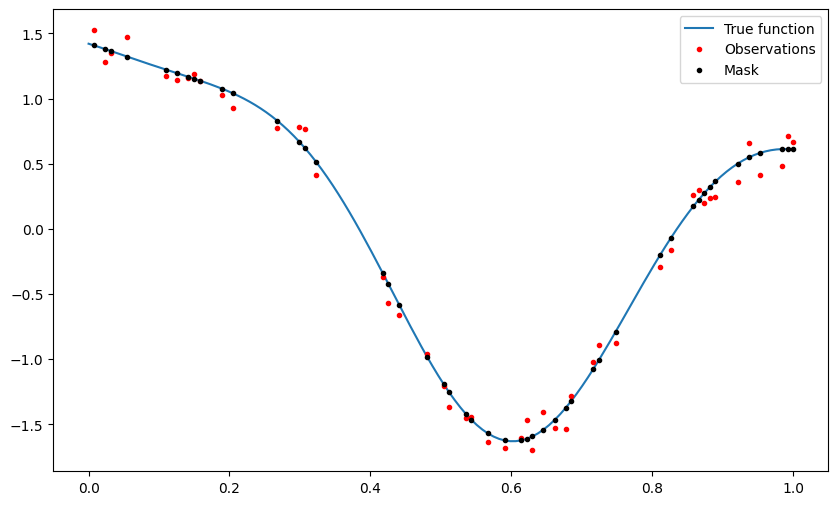

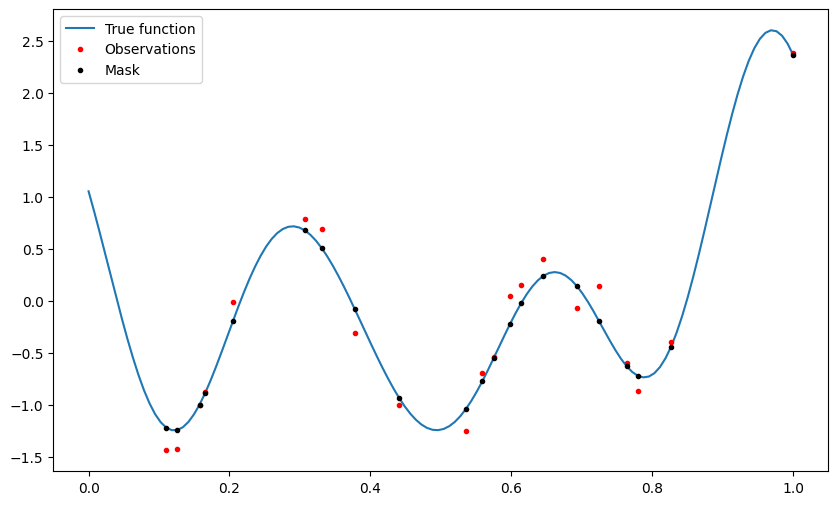

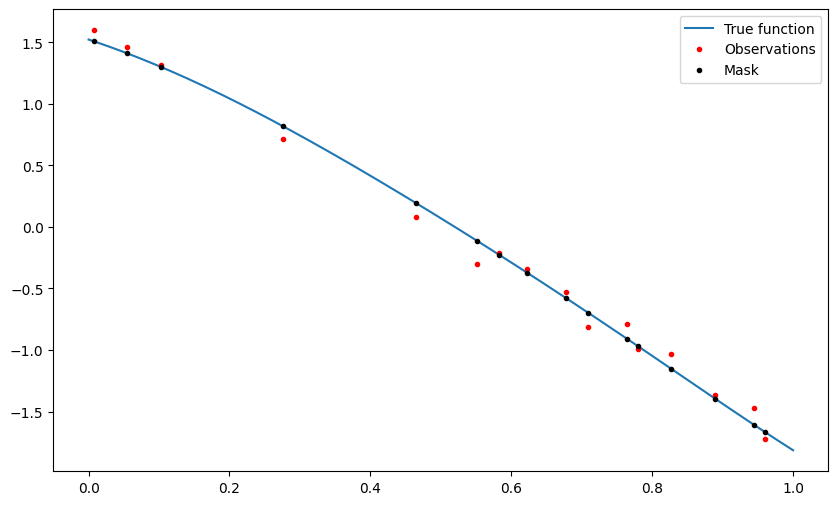

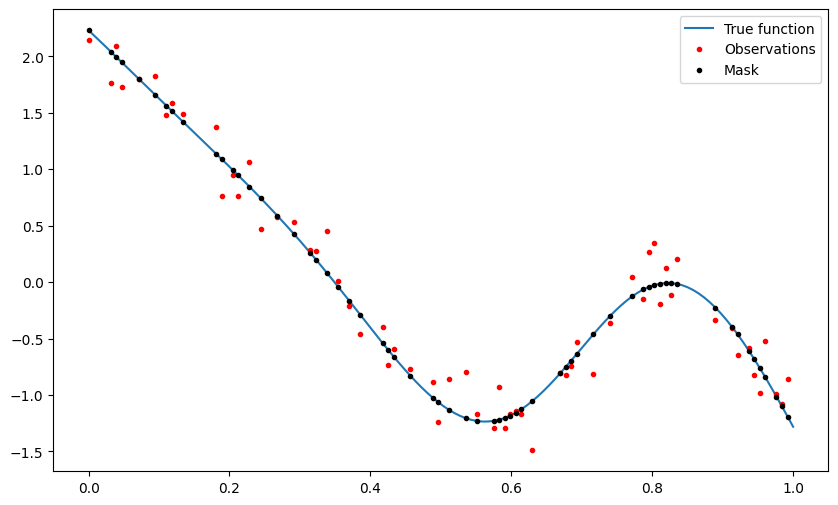

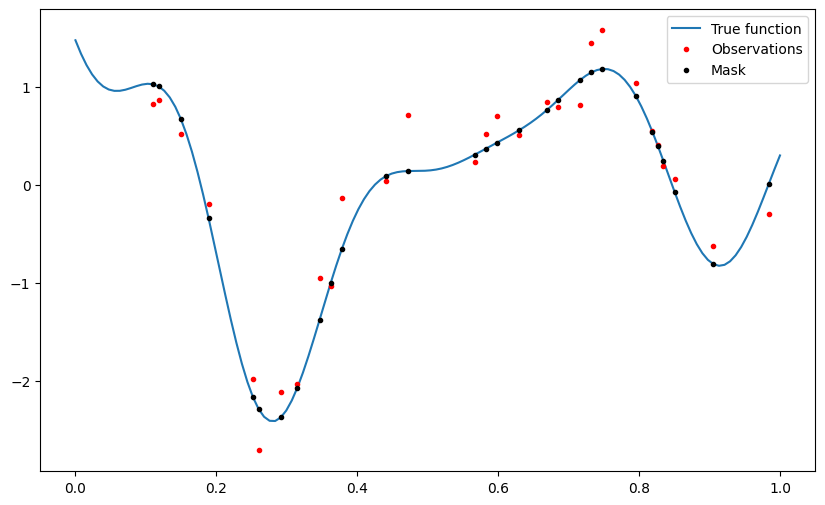

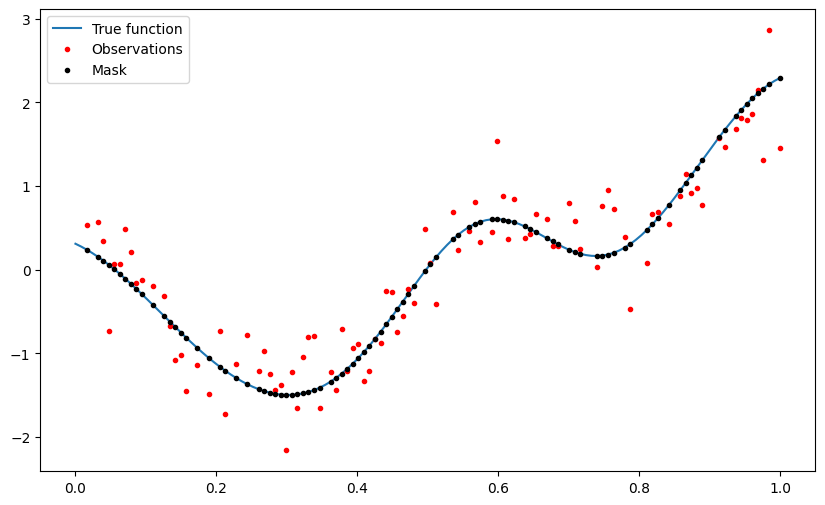

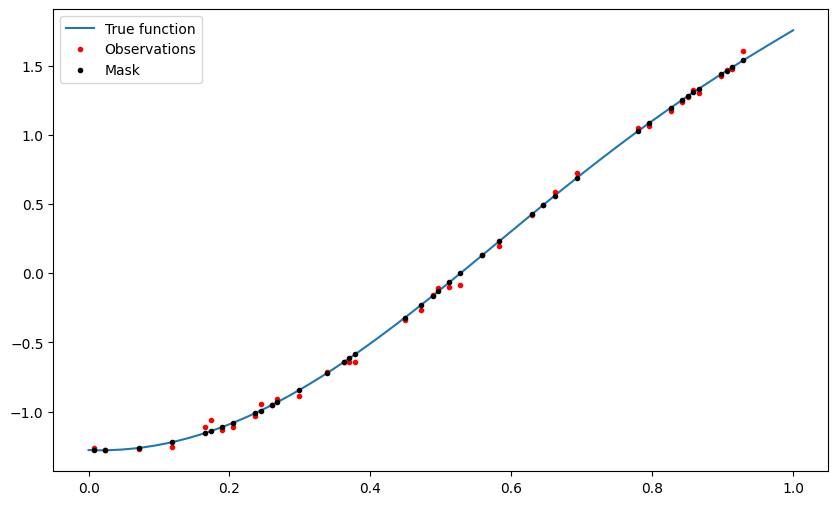

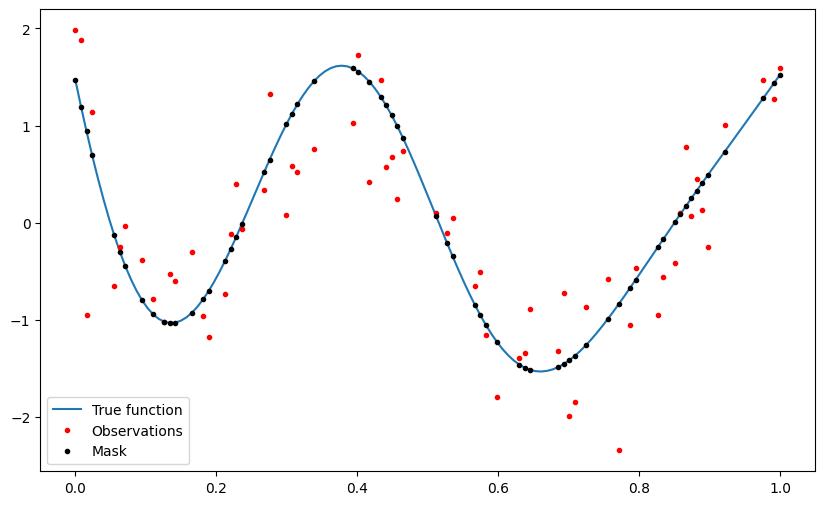

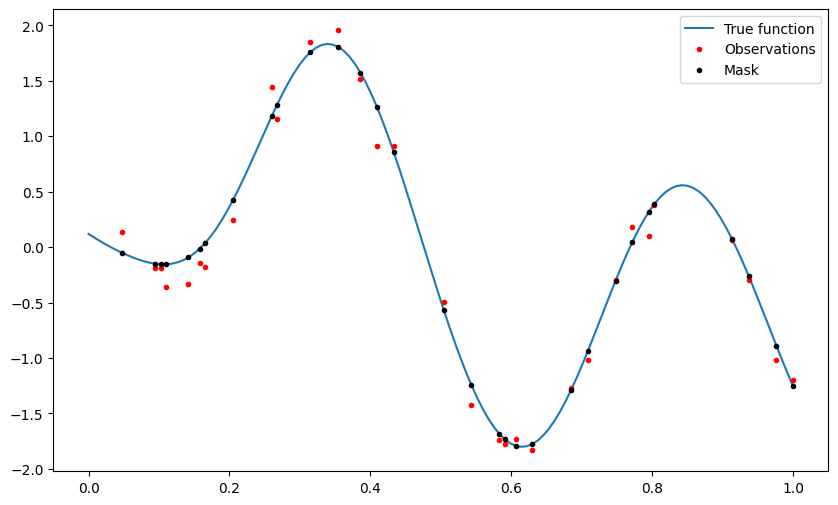

In [3]:
""" Visualize dataset """

X = np.linspace(0, 1, 128)
i = 0
for function_values, observations, masks in train_dataset:
    observation_values, observation_time_points = observations

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.plot(X[masks], function_values[masks], label='Mask',marker='.', color='black', linestyle='None')
    plt.legend()
    plt.show()
    i += 1
    if i == 10:
        break

In [ ]:
""" Using fixed padding to get sequence length of 128"""

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_fixed)
validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_fixed)

In [5]:
for (true_values, observations, masks) in train_loader:
    values, times = observations
    print(true_values.shape, values.shape, masks.shape)
    print(masks[0])
    print(values[0])
    print(times[0])
    break

torch.Size([256, 128]) torch.Size([256, 128]) torch.Size([256, 128])
tensor([  0.,   2.,   5.,   8.,  11.,  13.,  16.,  19.,  22.,  24.,  27.,  30.,
         33.,  35.,  38.,  41.,  44.,  46.,  49.,  52.,  55.,  57.,  60.,  63.,
         66.,  69.,  71.,  74.,  77.,  80.,  82.,  85.,  88.,  91.,  93.,  96.,
         99., 102., 104., 107., 110., 113., 115., 118., 121., 124., 127.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
tensor([ 2.0333,  2.3551,  1.5281,  1.8005,  1.1797,  1.7576,  1.0370,  1.

In [ ]:
""" Using dynamic padding to pad to the maximum sequence length in a batch """

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [4]:
for (true_values, observations, masks) in train_loader:
    values, times = observations
    print(true_values.shape, values.shape, masks.shape)
    print(masks[0])
    print(values[0])
    print(times[0])
    break

torch.Size([256, 128]) torch.Size([256, 100]) torch.Size([256, 100])
tensor([  0.,   2.,   5.,   7.,  10.,  12.,  15.,  17.,  20.,  22.,  25.,  27.,
         30.,  33.,  35.,  38.,  40.,  43.,  45.,  48.,  50.,  53.,  55.,  58.,
         60.,  63.,  66.,  68.,  71.,  73.,  76.,  78.,  81.,  83.,  86.,  88.,
         91.,  93.,  96.,  99., 101., 104., 106., 109., 111., 114., 116., 119.,
        121., 124., 127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.])
tensor([ 1.0052,  1.0045,  1.0366,  1.0050,  1.0555,  1.0169,  1.0658,  1.1152,
         1.1078,  1.0732,  1.0544,  1.0309,  1.0457,  0.9600,  0.8221,  0.8838,
         0.8456,  0.8460,  0.8327,  0.5860,  0.6798,  0.6114,  0.4720,  0.3858,
         0.3633,  